- plot shap_values for 
 - models #16 and #17
 - 5 samples and 50 samples
 - public and private data
- plot attr_all_22085_genes
 - models #16 and #17
 - use same samples as above
 - public and private data
- get_plot_per_cell_type() plots attributions coloured by cell type

In [9]:
%%capture output
!pip install shap
!pip install anndata
!pip install ipywidgets
!pip install --upgrade jupyter
!pip install IProgress

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import shap

import anndata as ad
import scipy

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [11]:
plt.rcParams['figure.dpi'] = 100

In [12]:
os.chdir('../..')

In [13]:
lrz_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/'
index_path = lrz_path + 'open-problems-multimodal-3rd-solution/input/preprocess/cite/'

In [14]:
# all_22001_genes: 22001 features, handselected_gene_ids: 84 handselected genes
all_22001_genes = np.loadtxt('2.preprocess_to_feature/cite/all_22001_genes_names.txt', dtype=str)
handselected_gene_ids = np.loadtxt('2.preprocess_to_feature/cite/handselected_84_gene_ids.txt', dtype=str)

In [15]:
# all 22085 genes sorted totally alphabetically
train_column = np.load(index_path + "train_cite_raw_inputs_idxcol.npz", allow_pickle=True)["columns"]
train_column

array(['ENSG00000121410_A1BG', 'ENSG00000268895_A1BG-AS1',
       'ENSG00000175899_A2M', ..., 'ENSG00000162378_ZYG11B',
       'ENSG00000159840_ZYX', 'ENSG00000074755_ZZEF1'], dtype=object)

In [16]:
# function for plotting shap values
def shap_beeswarm(shap_values, X_test):
    shap.initjs()
    shap.summary_plot(shap_values[0], X_test.to_df(), feature_names=X_test.var_names)

def shap_bar_plot(shap_values, X_test):
    shap.initjs()
    shap.summary_plot(list(shap_values), plot_type = 'bar', feature_names = X_test.var_names)
    # 140 classes = each regression output

In [17]:
# function for plotting backpropagated attribution values (new function because of other column order)
def attr_beeswarm(attr_values, X_test, protein_idx):
    # change column order to have all columns sorted and in same order as X_test
    attr_values[protein_idx] = attr_values[protein_idx].reindex(columns=train_column)
    shap.initjs()
    shap.summary_plot(np.array(attr_values[protein_idx]), X_test, feature_names=X_test.columns)

In [18]:
# get top n features from shap plots
def get_top_features(shap_values, xtest, top_n):
    shap_sum = np.abs(shap_values).sum(axis=0)
    top_features_indices = np.argsort(shap_sum)[::-1][:top_n]  # Get the indices of the top n features
    top_feature_names_shap = xtest.var_names[top_features_indices]
    return top_feature_names_shap

In [19]:
# function for plot: plot top 10 features colouring datapoints by cell type
def get_plot_per_cell_type(shap_values, xtest, protein_idx=0, show=True, save=False, filename=None, all_attr=False):   # all_attr=True if attr_all_genes passed instead of svd shap values
    
    if all_attr:
        # in this case: have 22085 columns, not totally sorted but first 22001 columns sorted and next 84 columns sorted
        # => need total order (=train_column) to match xtest
        shap_values[protein_idx] = shap_values[protein_idx].reindex(columns=train_column)

    # get top 10 features (see shap beeswarm plot)
    top_feature_names_shap = get_top_features(shap_values[protein_idx], xtest, 10)
    
    # create df with shap values of top 10 features + cell type    
    shap_cell_types = {}
    for feature in top_feature_names_shap:
        column_name = 'SHAP ' + feature.split('_')[-1]
        # column_values = shap_values[0, :, xtest.var_names.get_loc(feature)]   # use this if shap_values 3D array
        column_values = np.array(shap_values[protein_idx])[:, xtest.var_names.get_loc(feature)]   # use this if shap_values (or attr_all_22085...) dict of dataframes
        shap_cell_types[column_name] = column_values

    # Add 'Cell Type' column
    shap_cell_types['Cell Type'] = xtest.obs['cell_type']

    # Create DataFrame
    shap_cell_types = pd.DataFrame(shap_cell_types)

    
    # code for actual plot:

    # Assign different colors to each class
    colors = {'BP': 'red', 'EryP': 'blue', 'HSC': 'green', 'MasP': 'orange', 'MkP': 'purple', 'MoP': 'yellow', 'NeuP': 'pink'}

    ## legend ##
    legend_fig, legend_ax = plt.subplots(figsize=(2, 2))

    for class_label, color in colors.items():
        legend_ax.scatter([], [], color=color, label=f'Cell type {class_label}')

    legend_ax.legend(loc='center', bbox_to_anchor=(0.5, 1.2), ncol=len(colors), frameon=False)
    legend_ax.axis('off')
    ## legend ##


    # plot shap values:
    fig, ax = plt.subplots(figsize=(8, 10))

    # x_limit = (shap_values[protein_idx].min()-0.05, shap_values[protein_idx].max()+0.05)  # this is min and max for shap_values[protein_idx]
    x_limit = (shap_values[protein_idx].min().min()-0.05, shap_values[protein_idx].max().max()+0.05)  # above if array, this row if dict of dataframes
    
    # Remove y-axis ticks and labels
    ax.yaxis.set_visible(False)

    class_offsets = {}   # add vertical offset per class
    y = 0
    # Iterate over the columns in shap_cell_types to create subplots
    for i, column in enumerate(shap_cell_types.columns[:-1], start=1):

        ax = fig.add_subplot(len(shap_cell_types.columns)-1, 1, i)

        # Set the x-axis limits and label
        ax.set_xlim(x_limit)
        ax.set_xlabel(column)

        ax.yaxis.set_visible(False)

        # Plot the dots for the current column
        for index, row in shap_cell_types.iterrows():
            shap_value = row[column]
            class_label = row['Cell Type']
            color = colors[class_label]
            
            ##### add vertical offset per class ###
            # Check if the class_label is already in the class_offsets dictionary
            if class_label not in class_offsets:
                class_offsets[class_label] = y

            # Add the vertical offset to the y-coordinate of the dot
            y_offset = class_offsets[class_label]
            ##### add vertical offset per class ###
            
            # ax.plot(shap_value, 0, marker='o', color=color, markersize=2)  # without offset
            ax.plot(shap_value, y_offset, marker='o', color=color, markersize=2)

            # Increment the vertical offset for the next class_label
            y += 1
            
            
        
            
    fig.tight_layout(rect=[0, 0.1, 1, 1]) 
    legend_fig.subplots_adjust(top=0.1, bottom=0.05)
    
    # save plot if save=True -> need to have filename as param
    if save:
        if filename is None:
            raise ValueError("A filename must be provided when save=True.")
        plt.savefig(f'4.model/pred/plots/{filename}.png')

    if show:
        plt.show()
    else:
        plt.close()

### list of target proteins, function to get their index

In [20]:
proteins = np.load('4.model/pred/proteins.npy', allow_pickle=True)
def get_protein_idx(protein):
    return np.where(proteins == protein)[0][0]

### plots for public data: ignore, use private data

#### plots for model #16

In [21]:
# shap_values = np.load('4.model/pred/shap_values_16_50_samples_restructured.npy', allow_pickle=True).astype(float)
# xtest = ad.read_h5ad('4.model/pred/X_test_shap_16_50_samples.h5ad')
# xtest

In [22]:
# shap_beeswarm(shap_values, xtest)   # plots only svd components
# goal: get this plot as SHAP / features instead of SHAP / SVD components + features

In [23]:
# shap_bar_plot(shap_values, xtest)   # only svd components

#### shap plot with backpropagated gene attributions

In [24]:
# test_inputs = scipy.sparse.load_npz(index_path + "test_cite_raw_inputs_values.sparse.npz")
# test_inputs = pd.DataFrame(test_inputs.toarray(), columns=train_column)   # should be correct order (totally ordered)

# # get cell ids
# test_ids = np.load(index_path + "test_cite_raw_inputs_idxcol.npz", allow_pickle=True)
# test_index = test_ids["index"]
# len(test_index)

# test_inputs.index = test_index

# test_inputs.head(2)

In [25]:
# cell ids used in xtest and SHAP:
# sample_cells = xtest.obs_names
# sample_cells

In [26]:
# create xtest_all_genes: for shap plot, containing all 22085 genes instead of svd components
# xtest_all_genes = test_inputs.loc[sample_cells]
# print(xtest_all_genes.shape)
# xtest_all_genes.head(2)

In [27]:
# attr_all_22085_genes = pd.read_pickle(lrz_path + 'large_preprocessed_files/attr_all_genes/attr_all_22085_genes_16_50_samples_med.pkl')
# attr_all_22085_genes[0].head(2)

In [28]:
# attr_beeswarm(attr_all_22085_genes, xtest_all_genes, 0)  # public data -> consider private instead, see below

In [29]:
# get top 20 features (see shap beeswarm plot)
# top_20 = get_top_features(attr_all_22085_genes[0], ad.AnnData(xtest_all_genes), 20)
# print(top_20)
# np.save('4.model/pred/top_feature_names_16.npy', top_20)

#### plot shap values per cell type similar to shap.summary_plot(shap_values[0], xtest)

In [30]:
# consider private data below instead
# get_plot_per_cell_type(attr_all_22085_genes, ad.AnnData(X=xtest_all_genes, obs=xtest.obs), save=True, filename='attr_16_50_samples', all_attr=True)

#### plots for model #17

In [31]:
# shap_values = np.load('shap_values_16_50_samples.npy', allow_pickle=True).astype(float)
# shap_values = np.load('4.model/pred/shap_values_16_restructured.npy', allow_pickle=True).astype(float)
# shap_values = np.load('4.model/pred/shap_values_17_50_samples_restructured.npy', allow_pickle=True).astype(float)
# xtest = ad.read_h5ad('4.model/pred/X_test_shap_17_50_samples.h5ad')
# xtest

In [32]:
# shap_beeswarm(shap_values, xtest)   # only svd components
# goal: get this plot as SHAP / features instead of SHAP / SVD components + features

#### shap plot with backpropagated gene attributions

In [33]:
# attr_all_22085_genes = pd.read_pickle(lrz_path + 'large_preprocessed_files/attr_all_genes/attr_all_22085_genes_17_50_samples.pkl')
# attr_all_22085_genes[0].head(2)

In [34]:
# attr_beeswarm(attr_all_22085_genes, xtest_all_genes, 0)   # consider private data below instead

In [35]:
# get top 20 features (see shap beeswarm plot)
# top_20 = get_top_features(attr_all_22085_genes[0], ad.AnnData(xtest_all_genes), 20)
# print(top_20)
# np.save('4.model/pred/top_feature_names_17.npy', top_20)

In [36]:
# consider private data below instead
# get_plot_per_cell_type(attr_all_22085_genes, ad.AnnData(X=xtest_all_genes, obs=xtest.obs), save=True, filename='attr_17_50_samples', all_attr=True)

## plots for private data

#### plots for model #16

In [37]:
# shap_values = np.load('4.model/pred/shap_values_16_50_samples_p.npy', allow_pickle=True).astype(float)
shap_values = np.load('4.model/pred/shap_values_16_50_samples_p_ct_distr.npy', allow_pickle=True).astype(float)
xtest = ad.read_h5ad('4.model/pred/private_test_input_128_svd_50_samples.h5ad')
xtest

AnnData object with n_obs × n_vars = 350 × 212
    obs: 'kaggle_dataset', 'day', 'donor', 'cell_type'

In [38]:
# shap_beeswarm(shap_values, xtest)   # only svd components
# goal: get this plot as SHAP / features instead of SHAP / SVD components + features

#### shap plot with backpropagated gene attributions

In [39]:
# load private test input data (before svd)
# private_test_input instead? -> same plots, just higher feature values -> more red
private_test_input_raw = pd.read_pickle('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data/20220830_citeseq_rna_count_test_input_private_raw.pkl')
# private_test_input_raw.head()

In [40]:
# same cell ids used in xtest and SHAP:
sample_cells = np.array(xtest.obs_names)
# sample_cells[:5]

In [41]:
# create xtest_all_genes: for shap plot, containing all 22085 genes instead of svd components
xtest_all_genes = private_test_input_raw.loc[sample_cells]
print(xtest_all_genes.shape)
# xtest_all_genes.head()

(350, 22085)


In [42]:
attr_all_22085_genes = pd.read_pickle(lrz_path + 'large_preprocessed_files/attr_all_genes/attr_all_22085_genes_16_50_samples_p_ct_distr.pkl')
attr_all_22085_genes[0].shape

(350, 22085)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


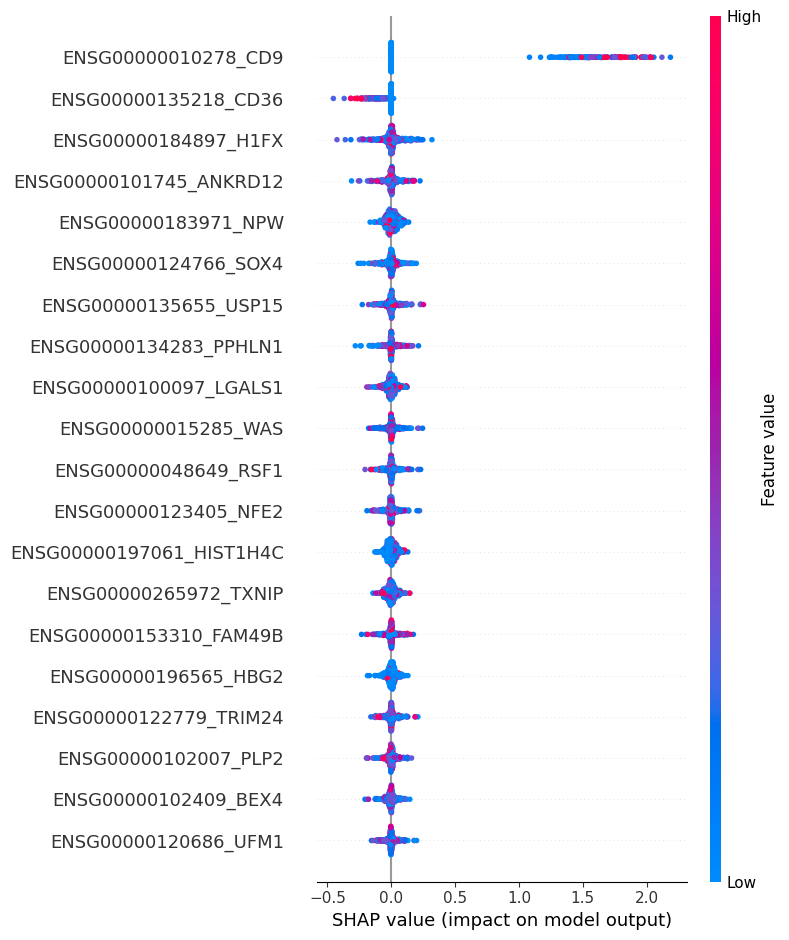

In [51]:
 attr_beeswarm(attr_all_22085_genes, xtest_all_genes, get_protein_idx('CD9'))   # CD274 interesting

X converted to numpy array with dtype float64


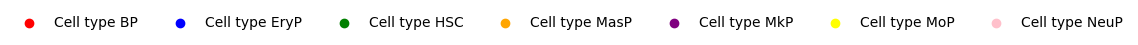

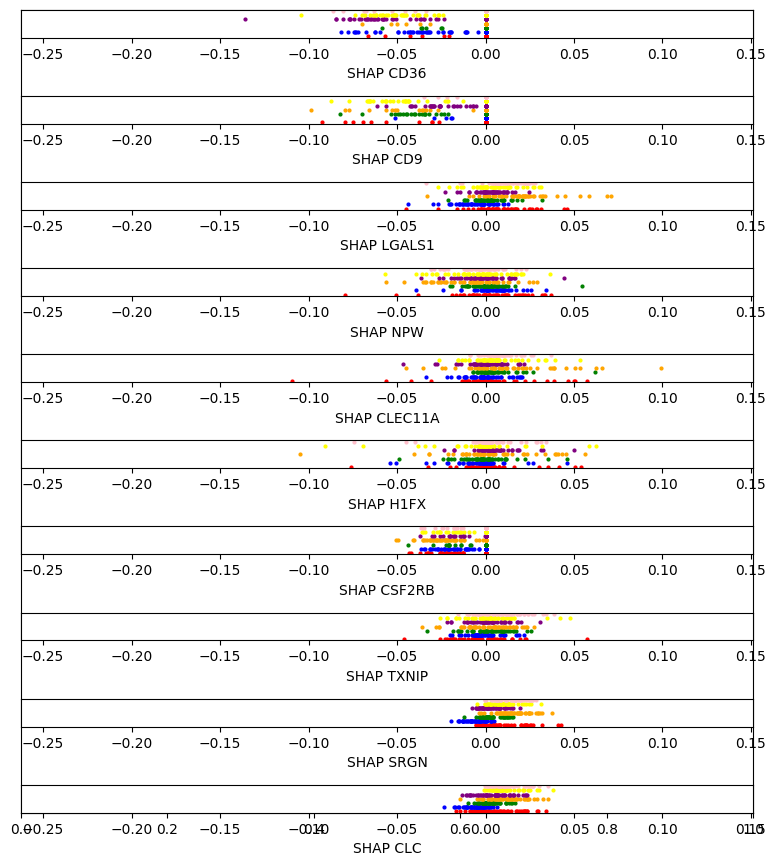

In [51]:
get_plot_per_cell_type(attr_all_22085_genes, ad.AnnData(X=xtest_all_genes, obs=xtest.obs, dtype=xtest_all_genes.dtypes), 0, save=True, filename='attr_16_50_samples_p', all_attr=True)

In [47]:
# get top 20 features (see shap beeswarm plot)
top_20 = get_top_features(attr_all_22085_genes[0], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20)
print(top_20)
# np.save('4.model/pred/top_feature_names_16_p.npy', top_20)

Index(['ENSG00000135218_CD36', 'ENSG00000010278_CD9', 'ENSG00000100097_LGALS1',
       'ENSG00000183971_NPW', 'ENSG00000105472_CLEC11A',
       'ENSG00000184897_H1FX', 'ENSG00000100368_CSF2RB',
       'ENSG00000265972_TXNIP', 'ENSG00000122862_SRGN', 'ENSG00000105205_CLC',
       'ENSG00000236824_BCYRN1', 'ENSG00000125148_MT2A',
       'ENSG00000077984_CST7', 'ENSG00000245532_NEAT1', 'ENSG00000124766_SOX4',
       'ENSG00000244734_HBB', 'ENSG00000005381_MPO', 'ENSG00000101745_ANKRD12',
       'ENSG00000163191_S100A11', 'ENSG00000105383_CD33'],
      dtype='object', name='gene_ids')


X converted to numpy array with dtype float64


X converted to numpy array with dtype float64


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


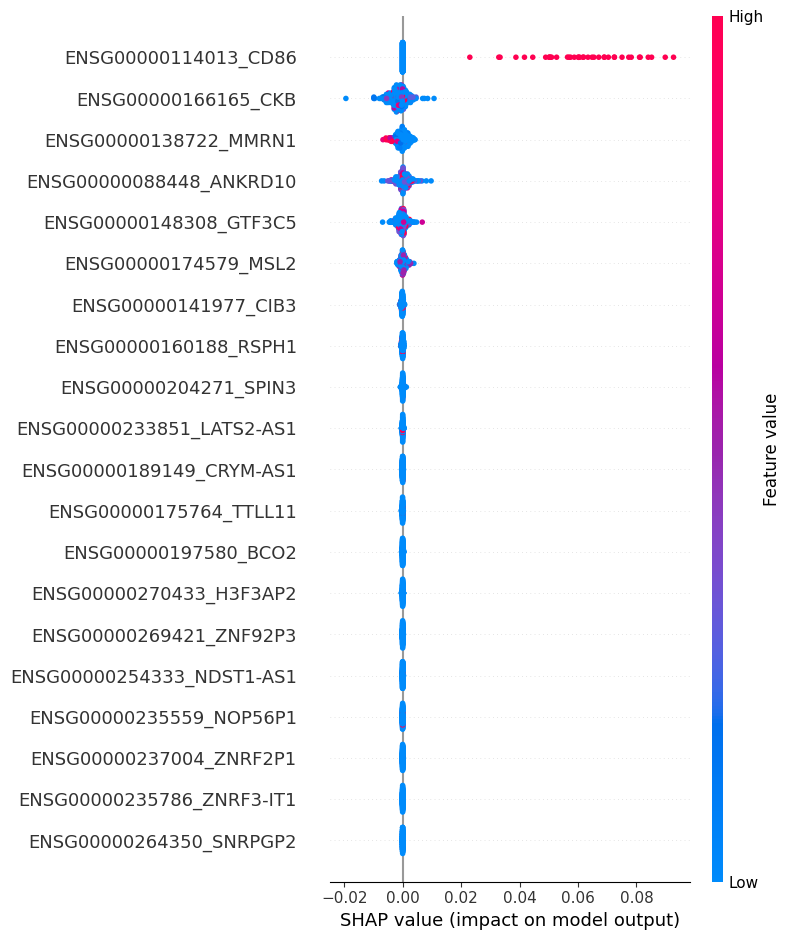

In [46]:
# subset attr_all_22085_genes: any 19 plus the column we want
# force plot to show specific column
# see why 86 ranked low
idx = get_protein_idx('CD86')
top_19 = get_top_features(attr_all_22085_genes[idx], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 19)
corresp_gene = [col for col in attr_all_22085_genes[idx].columns if 'CD86' in col]
subset = attr_all_22085_genes[idx][list(top_19)+corresp_gene]
shap.initjs()
shap.summary_plot(np.array(subset), xtest_all_genes[subset.columns], feature_names=subset.columns)

X converted to numpy array with dtype float64


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


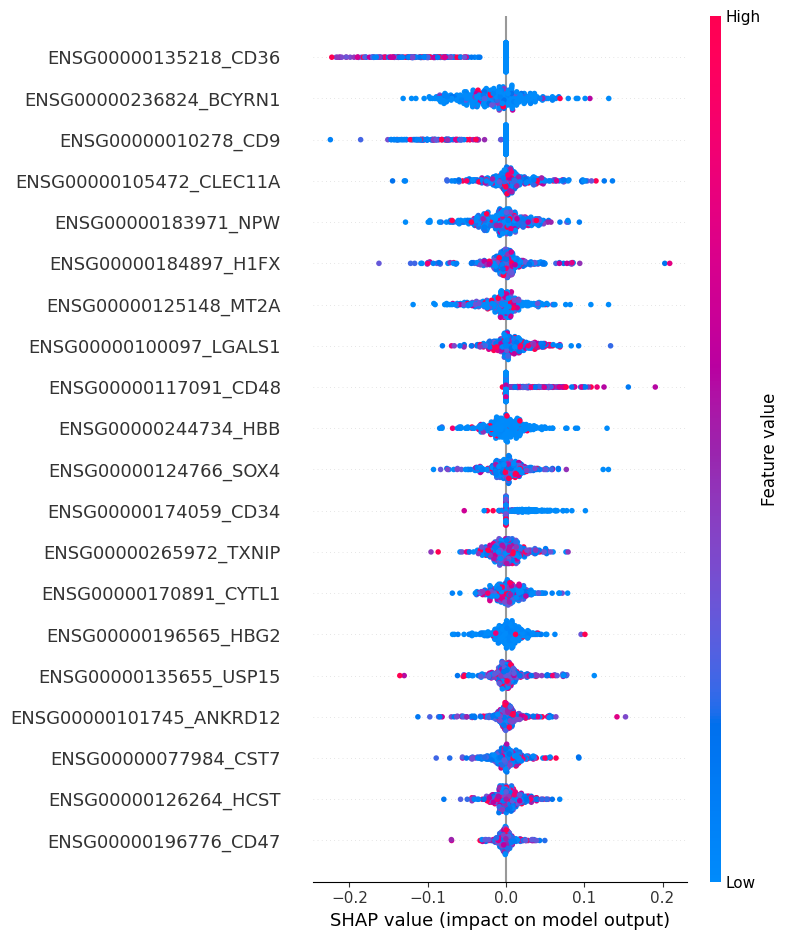

In [109]:
# see why 47 ranked low
idx = get_protein_idx('CD47')
top_19 = get_top_features(attr_all_22085_genes[idx], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 19)
corresp_gene = [col for col in attr_all_22085_genes[idx].columns if 'CD47' in col]
subset = attr_all_22085_genes[idx][list(top_19)+corresp_gene]
shap.initjs()
shap.summary_plot(np.array(subset), xtest_all_genes[subset.columns], feature_names=subset.columns)

X converted to numpy array with dtype float64


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


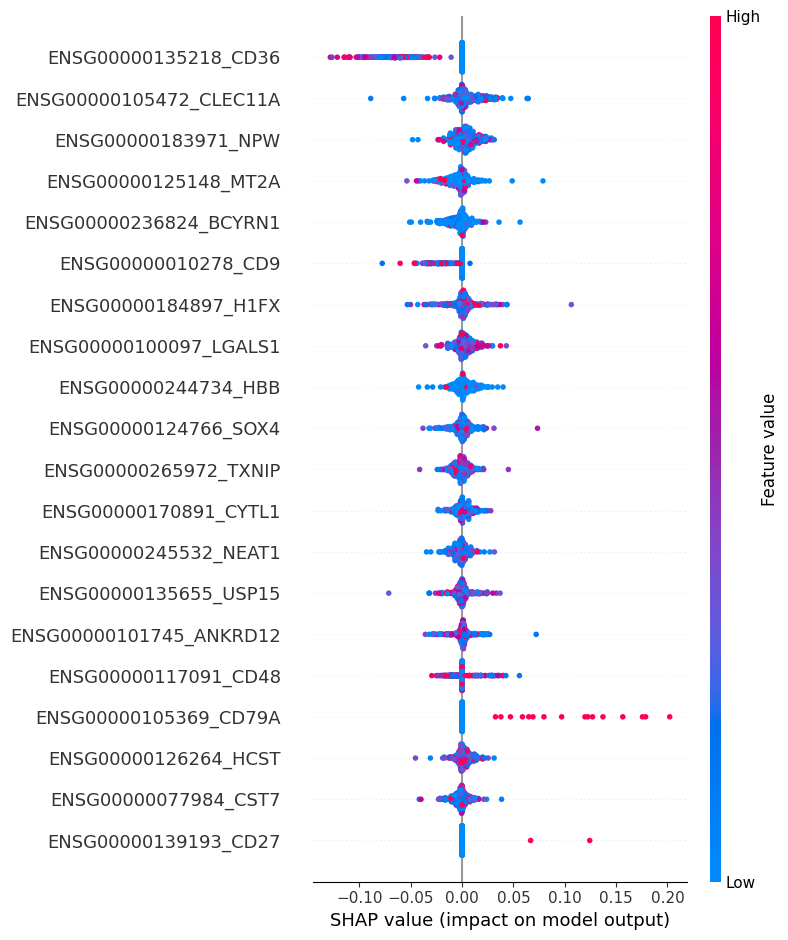

In [48]:
# see why 27 ranked low
idx = get_protein_idx('CD27')
top_19 = get_top_features(attr_all_22085_genes[idx], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 19)
corresp_gene = [col for col in attr_all_22085_genes[idx].columns if 'CD27' in col]
subset = attr_all_22085_genes[idx][list(top_19)+corresp_gene]
shap.initjs()
shap.summary_plot(np.array(subset), xtest_all_genes[subset.columns], feature_names=subset.columns)

#### plots for model #17

In [116]:
# shap_values = np.load('4.model/pred/shap_values_17_50_samples_p.npy', allow_pickle=True).astype(float)
xtest_17 = ad.read_h5ad('4.model/pred/private_test_input_64_svd_50_samples.h5ad')
# xtest_17

AnnData object with n_obs × n_vars = 350 × 148
    obs: 'kaggle_dataset', 'day', 'donor', 'cell_type'

In [38]:
# shap_beeswarm(shap_values, xtest)   # only svd components
# goal: get this plot as SHAP / features instead of SHAP / SVD components + features

#### shap plot with backpropagated gene attributions

In [54]:
attr_all_22085_genes_17 = pd.read_pickle(lrz_path + 'large_preprocessed_files/attr_all_genes/attr_all_22085_genes_17_50_samples_p_ct_distr.pkl')
attr_all_22085_genes_17[0].head(2)

,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000188404_SELL,ENSG00000124570_SERPINB6,ENSG00000235169_SMIM1,ENSG00000095932_SMIM24,ENSG00000137642_SORL1,ENSG00000128040_SPINK2,ENSG00000072274_TFRC,ENSG00000205542_TMSB4X,ENSG00000133112_TPT1,ENSG00000026025_VIM
0,0.000136,0.000431,0.000498,0.000939,0.000007,-0.000766,-0.003348,-0.000048,-0.00022,-0.000737,...,-0.006766,-0.020778,0.0,0.000000,0.000000,0.000000,-0.011902,0.000000,-0.024068,0.0
1,-0.000138,0.000377,0.001151,0.001888,0.000066,-0.002372,0.006538,0.001002,0.00110,0.002942,...,0.000000,-0.014653,0.0,0.011124,-0.026157,0.012642,-0.013345,-0.009018,0.000000,0.0


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


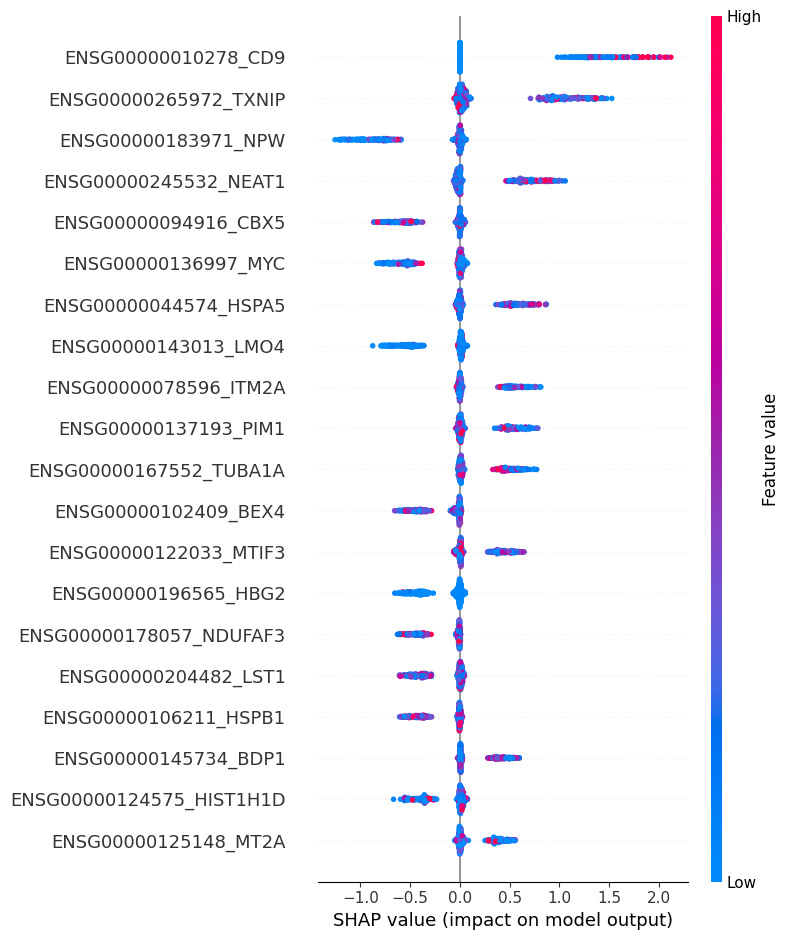

In [57]:
attr_beeswarm(attr_all_22085_genes_17, xtest_all_genes, get_protein_idx('CD9'))
# 121: maybe: model 17 checks if CD9 important at all (binary), model 16 gives actual value

In [120]:
# get top 20 features (see shap beeswarm plot)
top_20 = get_top_features(attr_all_22085_genes_17[get_protein_idx('CD9')], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20) 
print(top_20)
# np.save('4.model/pred/top_feature_names_17_p.npy', top_20)

Index(['ENSG00000010278_CD9', 'ENSG00000265972_TXNIP', 'ENSG00000183971_NPW',
       'ENSG00000245532_NEAT1', 'ENSG00000094916_CBX5', 'ENSG00000136997_MYC',
       'ENSG00000044574_HSPA5', 'ENSG00000143013_LMO4',
       'ENSG00000078596_ITM2A', 'ENSG00000137193_PIM1',
       'ENSG00000167552_TUBA1A', 'ENSG00000102409_BEX4',
       'ENSG00000122033_MTIF3', 'ENSG00000196565_HBG2',
       'ENSG00000178057_NDUFAF3', 'ENSG00000204482_LST1',
       'ENSG00000106211_HSPB1', 'ENSG00000145734_BDP1',
       'ENSG00000124575_HIST1H1D', 'ENSG00000125148_MT2A'],
      dtype='object', name='gene_ids')


X converted to numpy array with dtype float64


X converted to numpy array with dtype float64


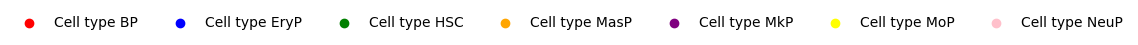

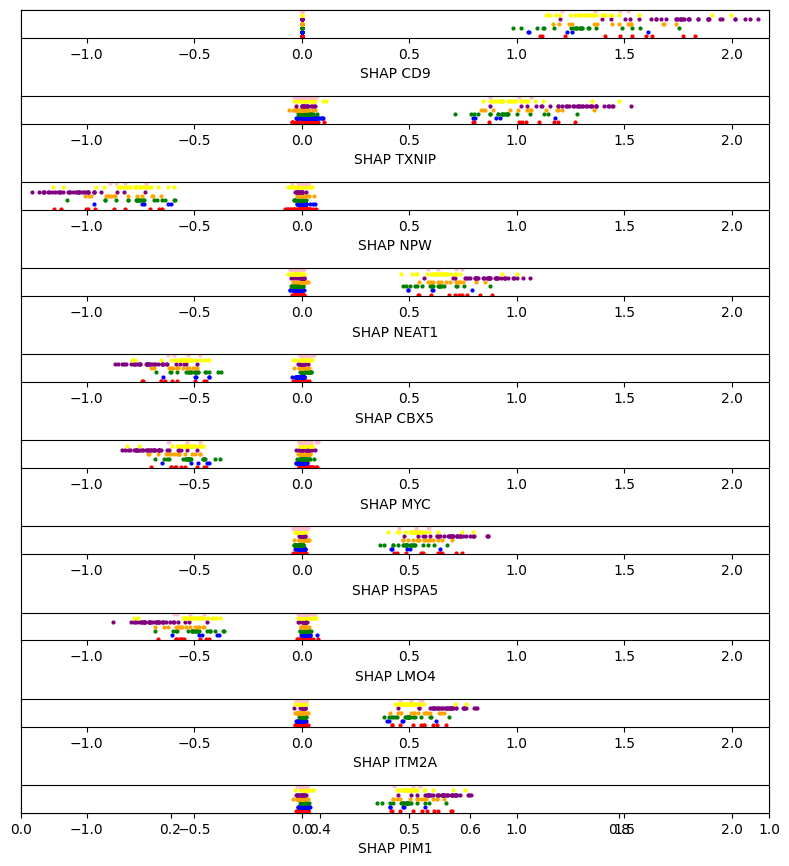

In [121]:
get_plot_per_cell_type(attr_all_22085_genes_17, ad.AnnData(X=xtest_all_genes, obs=xtest_17.obs, dtype=xtest_all_genes.dtypes), get_protein_idx('CD9'), save=True, filename='attr_17_50_samples_p', all_attr=True)

X converted to numpy array with dtype float64


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


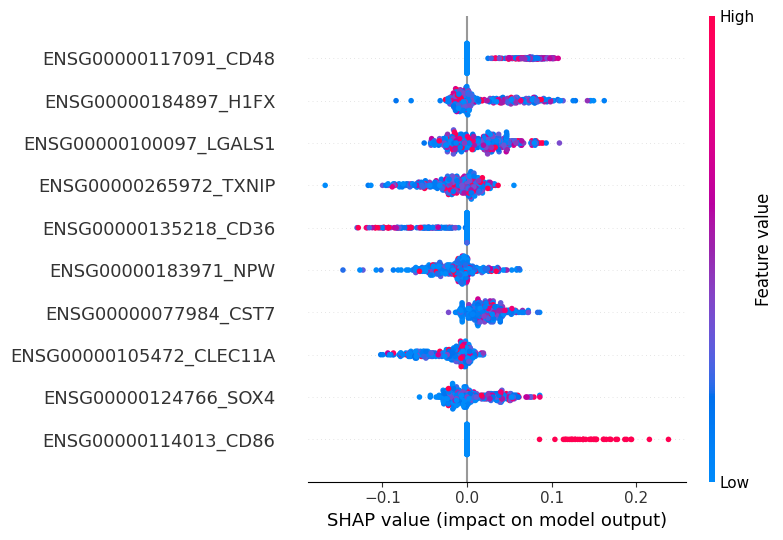

In [130]:
# subset attr_all_22085_genes: any 19 plus the column we want
# force plot to show specific column
# see why 86 ranked low
idx = get_protein_idx('CD86')
top_9 = get_top_features(attr_all_22085_genes_17[idx], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 9)
corresp_gene = [col for col in attr_all_22085_genes_17[idx].columns if 'CD86' in col]
subset = attr_all_22085_genes_17[idx][list(top_9)+corresp_gene]
shap.initjs()
shap.summary_plot(np.array(subset), xtest_all_genes[subset.columns], feature_names=subset.columns)

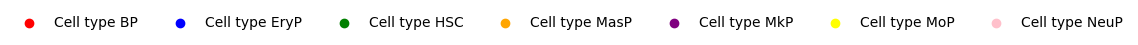

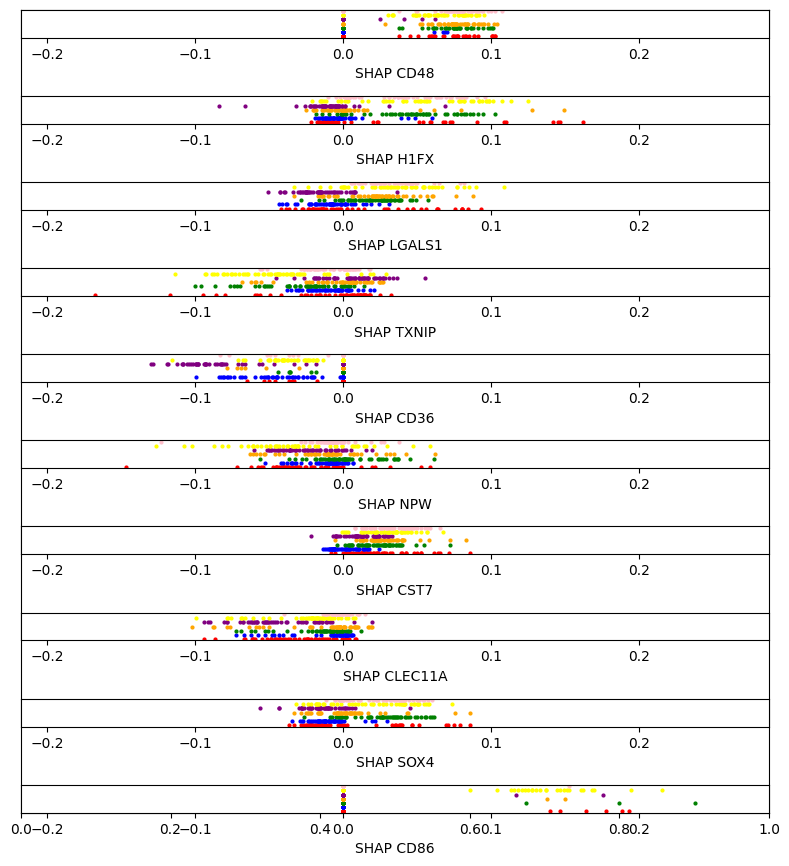

In [131]:
get_plot_per_cell_type([subset], ad.AnnData(X=xtest_all_genes[subset.columns], obs=xtest_17.obs, dtype=xtest_all_genes[subset.columns].dtypes), all_attr=False)